# -2) function definition

In [1]:
def stop_session():
    """
    Stop global spark session and spark context
    """
    try    : spark.stop()
    except : pass
    try    : sc.stop()
    except : pass
    

In [2]:
def get_new_session(master, appName, nb_cores):
    """
    Manage session creation with given appname and nb of cores.
    Parameters :
        Master   : string (spark url to master - spark://xx.xx.xx.xx:port)
        appName  : string
        nb_cores : int
    Return:
        (spark, sc)
        
    """
    stop_session()
    spark = SparkSession.builder.master(master).appName(appName).config("spark.cores.max", nb_cores).getOrCreate()
    sc    = spark.sparkContext
    return spark, sc

# -1) Imports

In [3]:
# PYTHON
from time              import time
from datetime          import datetime
from collections       import OrderedDict

# SPARK
from pyspark           import SparkConf
from pyspark           import SparkContext
from pyspark.sql       import SparkSession
from pyspark.sql.types import *


# 0) App configuration

In [4]:
user         = "romain"
current_date = datetime.now().strftime("%Y-%m-%d %H:%M")
master       = "spark://193.70.43.207:7077"
appName      = "%s le %s"%(user, current_date)
nb_cores     = 11

# 1) creating new session

In [5]:
spark, sc = get_new_session(master, appName, nb_cores)

# 2) Reading hdfs into rdd

In [6]:
hdfs_master = "hdfs://193.70.43.207:8020"
hdfs_path   = "/logs/cycliste_debug/2017/2017_02/2017_02_20/23h/23h20/*"
hdfs_path   = "/logs/cycliste_debug/2017/2017_02/2017_02_20/23h/23h18"
hdfs_path   = "/logs/trajets/2017/2017_03/2017_03_11/23h/23h0*/*"
target_path = hdfs_master+hdfs_path

In [7]:
rdd = sc.textFile(target_path)

In [8]:
rdd.take(1)

[u'aetpv,cycliste_azpfl,velo_azkn6_1489256539.78,1489269871.77,1489269872.95,1.17296504974,5.0,aekw6']

In [9]:
debut = time()
nb_de_ligne = rdd.count()
duree = time() - debut
print "duree pour rdd.count() = %s pour %s lignes "%(duree, nb_de_ligne)

duree pour rdd.count() = 17.5896041393 pour 184846 lignes 


# 2.1) Spark monte en mémoire les informations déjà calculées

In [10]:
debut = time()
nb_de_ligne = rdd.count()
duree = time() - debut
print "duree pour rdd.count() = %s pour %s lignes "%(duree, nb_de_ligne)

duree pour rdd.count() = 11.8767199516 pour 184846 lignes 


# 2.2) on peut aussi forcer la mise en mémoire => [fonction 'cache' ] 

In [33]:
print "on cache la rdd"
rdd.cache()

on cache la rdd


hdfs://193.70.43.207:8020/logs/trajets/2017/2017_03/2017_03_11/23h/23h0*/* MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:-2

In [34]:
debut = time()
nb_de_ligne = rdd.count()
duree = time() - debut
print "duree pour rdd.count() = %s pour %s lignes "%(duree, nb_de_ligne)

duree pour rdd.count() = 8.68542218208 pour 184846 lignes 


# 2.3) testing performance by number of cores

In [35]:
if False:
    perfs = {}

In [36]:
if False:
    for nb_cores in range(3,20):
        spark, sc = get_new_session(master, appName, nb_cores)
        debut     = time()
        rdd     = sc.textFile(target_path)
        rdd.count()
        duree     = time() - debut
        perfs[nb_cores] = duree
        print nb_cores, "%.1f sec"%duree


# 3) Creating a DataFrame

In [37]:
target_path

'hdfs://193.70.43.207:8020/logs/trajets/2017/2017_03/2017_03_11/23h/23h0*/*'

In [38]:
df = spark.read.option("header", True).csv(target_path)

In [39]:
df.take(1)

[Row(aetpv=u'aexv8', cycliste_azpfl=u'cycliste_azqh3', velo_azkn6_1489256539.78=u'velo_aeuln_1489256540.14', 1489269871.77=u'1489269871.77', 1489269872.95=u'1489269872.95', 1.17296504974=u'1.17120194435', 5.0=u'3.0', aekw6=u'azqm6')]

In [40]:
debut = time()
nb_row = df.count()
duree = time() - debut
print "duree du count = %s pour %s lignes"%(duree, nb_row)

duree du count = 3.14616799355 pour 184797 lignes


# 3.1) Préciser le schéma

creation du schema

In [41]:
champs = OrderedDict([("station_depart"     , StringType() ) ,
                      ("cycliste"           , StringType() ) ,
                      ("velo"               , StringType() ) ,
                      ("heure_de_depart"    , FloatType()  ) ,
                      ("heure_de_fin"       , FloatType()  ) ,
                      ("duree"              , FloatType()  ) ,
                      ("distance"           , FloatType()  ) ,
                      ("station_arrivee"    , StringType() ) ])

In [42]:
fields = [StructField(champ, _type, nullable = True) for champ, _type in champs.iteritems()]

In [43]:
schema = StructType(fields)

Application à la lecture du fichier :

In [44]:
df_avec_schema = spark.read.schema(schema).csv(target_path)

In [45]:
df_avec_schema.show(1)

+--------------+--------------+--------------------+---------------+------------+--------+--------+---------------+
|station_depart|      cycliste|                velo|heure_de_depart|heure_de_fin|   duree|distance|station_arrivee|
+--------------+--------------+--------------------+---------------+------------+--------+--------+---------------+
|         aetpv|cycliste_azpfl|velo_azkn6_148925...|   1.48926989E9|1.48926989E9|1.172965|     5.0|          aekw6|
+--------------+--------------+--------------------+---------------+------------+--------+--------+---------------+
only showing top 1 row



In [46]:
df_avec_schema.count()

184846

In [47]:
df_avec_schema.distinct().count()

126718

In [48]:
df_avec_schema.select("heure_de_depart").distinct().collect()

[Row(heure_de_depart=1489269888.0),
 Row(heure_de_depart=1489270144.0),
 Row(heure_de_depart=1489270016.0)]

In [49]:
df_avec_schema.select("duree").distinct().count()

107814

In [50]:
df_avec_schema.select("heure_de_fin").distinct().collect()

[Row(heure_de_fin=1489269888.0),
 Row(heure_de_fin=1489270144.0),
 Row(heure_de_fin=1489270016.0)]

# 3.2) Avec une df on peut sélectionner les colonnes par leur nom

In [51]:
df_avec_schema.select("cycliste").take(10)

[Row(cycliste=u'cycliste_azpfl'),
 Row(cycliste=u'cycliste_azqh3'),
 Row(cycliste=u'cycliste_azejx'),
 Row(cycliste=u'cycliste_azqw7'),
 Row(cycliste=u'cycliste_azys2'),
 Row(cycliste=u'cycliste_azrb8'),
 Row(cycliste=u'cycliste_azt48'),
 Row(cycliste=u'cycliste_aztn6'),
 Row(cycliste=u'cycliste_azio1'),
 Row(cycliste=u'cycliste_aztom')]

In [52]:
df_cyclistes = df_avec_schema.select("cycliste")

# 3.3) les dataframe sont plus rapides que les rdd

In [53]:
debut  = time()
nb_row = df_avec_schema.count()
duree  = time() - debut
print "duree du count = %.2f sec pour %s lignes"%(duree, nb_row)

duree du count = 1.51 sec pour 184846 lignes


In [54]:
# pour optimiser son code, il faut penser en terme de partitions, de filtres, etc...
cached_df.explain()

NameError: name 'cached_df' is not defined

# 3.3) Group BY

3.3.1) somme des distances par cycliste

In [ ]:
debut = time()
test = df_avec_schema.groupBy("cycliste").sum("distance")
test.take(2)
duree = time() -debut
print duree

In [ ]:
debut = time()
test.take(2)
duree = time() -debut
print duree

In [ ]:
test.cache()

In [ ]:
debut = time()
test.take(2)
duree = time() -debut
print duree

3.3.1) somme triée

In [ ]:
debut = time()
df_avec_schema.groupBy("cycliste").sum("distance").sort("sum(distance)",ascending=False).take(2)
duree = time() - debut
print duree

In [ ]:
debut = time()
test.sort("sum(distance)",ascending=False).take(2)
duree = time() - debut
print duree

In [ ]:
# moyenne
df_avec_schema.groupBy("cycliste").avg("distance").take(5)

In [ ]:
# count
df_avec_schema.groupBy("cycliste").count().take(5)

3.3.2) appel de fonctions simili-sql 

In [ ]:
# desc = tri descendant
from pyspark.sql.functions import desc

In [ ]:
df_avec_schema.groupBy("cycliste").sum("distance").sort(desc("sum(distance)")).take(2)

In [ ]:
# asc = tri ascendant
from pyspark.sql.functions import asc

In [ ]:
df_avec_schema.groupBy("cycliste").sum("distance").sort(asc("sum(distance)")).take(2)

3.3.3) mis en cache

In [ ]:
# still a lazy operation !
cahed_df = df_avec_schema.groupBy("cycliste").sum("distance").cache()

In [ ]:
cahed_df.take(13)

In [55]:
cached_df_2 = df_avec_schema.cache()

In [56]:
cached_df_2.show(2)

+--------------+--------------+--------------------+---------------+------------+--------+--------+---------------+
|station_depart|      cycliste|                velo|heure_de_depart|heure_de_fin|   duree|distance|station_arrivee|
+--------------+--------------+--------------------+---------------+------------+--------+--------+---------------+
|         aetpv|cycliste_azpfl|velo_azkn6_148925...|   1.48926989E9|1.48926989E9|1.172965|     5.0|          aekw6|
|         aexv8|cycliste_azqh3|velo_aeuln_148925...|   1.48926989E9|1.48926989E9|1.171202|     3.0|          azqm6|
+--------------+--------------+--------------------+---------------+------------+--------+--------+---------------+
only showing top 2 rows



In [ ]:
# double group
cached_df_2.groupBy(["cycliste", "station_depart"]).avg("distance").sort("cycliste").take(5)

In [ ]:
# enchainement de 5 transformation : groupby + count + sort + filter + select
groupBy   = ["cycliste", "station_depart"]
sortBy    = "cycliste"
filterBy  = 'cycliste == "cycliste_aze12"'
select    = ["station_depart", "count"]
cached_df_2.groupBy(groupBy).count().sort(sortBy).filter(filterBy).select(select).collect()

# Attention au Nommage de variables !

In [57]:
trajets = cached_df_2

In [58]:
trajets.show(1)

+--------------+--------------+--------------------+---------------+------------+--------+--------+---------------+
|station_depart|      cycliste|                velo|heure_de_depart|heure_de_fin|   duree|distance|station_arrivee|
+--------------+--------------+--------------------+---------------+------------+--------+--------+---------------+
|         aetpv|cycliste_azpfl|velo_azkn6_148925...|   1.48926989E9|1.48926989E9|1.172965|     5.0|          aekw6|
+--------------+--------------+--------------------+---------------+------------+--------+--------+---------------+
only showing top 1 row



# Nombre de trajets entre deux stations

In [ ]:
trajets.groupBy(["station_depart", "station_arrivee"]).count().orderBy("station_depart").take(2)

# 3.5) filtrer

In [ ]:
trajets.filter("distance > 3").count()

In [ ]:
trajets.groupby("cycliste").sum("distance").filter("70 < sum(distance) and sum(distance) <100").count()

# 3.6) Cycliste ayant fait la plus petite distance

In [59]:
from pyspark.sql import functions as F

In [60]:
distance_par_cycliste = trajets.groupby("cycliste").sum("distance")

In [ ]:
distance_par_cycliste.take(2)

In [61]:
distance_minimale = distance_par_cycliste.select(F.min("sum(distance)")).collect()

In [ ]:
row = distance_minimale
value = row[0][0]
value

In [ ]:
filtre = "sum(distance) <= %.14f"%(value)
filtre

In [ ]:
distance_par_cycliste.filter(filtre).select("cycliste").collect()[0][0]

# 4) Création de colonnes

In [62]:
plus_grande_distance = distance_par_cycliste.select(F.max("sum(distance)")).collect() [0][0]

# 4.1) on se sert de la fonction 'lit' pour créer une colonne avec un chiffre fixe

In [63]:
nouvelle_colonne        = F.lit(plus_grande_distance)
nouveau_nom             = "distance_max"
distance_par_cycliste_2 = distance_par_cycliste.withColumn(nouveau_nom, nouvelle_colonne)

# 4.2) on peut renommer une colonne

In [64]:
ancien_nom              = "sum(distance)"
nouveau_nom             = "distance_parcourue"
distance_par_cycliste_3 = distance_par_cycliste_2.withColumnRenamed(ancien_nom, nouveau_nom)

# 4.3) on peut faire un calcul entre deux colonnes de la même df

In [65]:
nouvelle_colonne        = distance_par_cycliste_3.distance_parcourue / distance_par_cycliste_3.distance_max
nouveau_nom             = "pct_de_la_distance_max"
distance_par_cycliste_4 = distance_par_cycliste_3.withColumn(nouveau_nom, nouvelle_colonne)

In [ ]:
distance_par_cycliste_4.show(3)

# 5) Bucketizer

In [66]:
import numpy as np
splits = np.arange(0,1.5,0.05)

In [67]:
splits

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
        1.35,  1.4 ,  1.45])

In [68]:
from pyspark.ml.feature import Bucketizer

bucketizer = Bucketizer(splits    = splits                  , 
                        inputCol  = "pct_de_la_distance_max", 
                        outputCol = "bucketed_distance"     )

In [69]:
bucketedData = bucketizer.transform(distance_par_cycliste_4)
bucketedData.show()

+--------------+------------------+-------------+----------------------+-----------------+
|      cycliste|distance_parcourue| distance_max|pct_de_la_distance_max|bucketed_distance|
+--------------+------------------+-------------+----------------------+-----------------+
|cycliste_azy78| 411.4287202358246|1007.73123837|    0.4082722699966197|              8.0|
|cycliste_azpqc| 619.9140572547913|1007.73123837|    0.6151581231693274|             12.0|
|cycliste_azem5| 540.1847624778748|1007.73123837|    0.5360405055534656|             10.0|
|cycliste_azyof| 488.1261043548584|1007.73123837|     0.484381237545439|              9.0|
|cycliste_azub0|280.58862829208374|1007.73123837|    0.2784359734108614|              5.0|
|cycliste_azrp9| 463.3761112689972|1007.73123837|    0.4598211245475585|              9.0|
|cycliste_azu45| 437.9169387817383|1007.73123837|    0.4345572729193814|              8.0|
|cycliste_azr15| 680.8278245925903|1007.73123837|    0.6756045646593488|             13.0|

# 5.1) Histogramme par bucket

In [70]:
bucketedData.groupBy("bucketed_distance").count().take(2)

[Row(bucketed_distance=8.0, count=204), Row(bucketed_distance=7.0, count=174)]

# 5.2) Passage de Spark à Python

In [71]:
nb_cycliste_par_pctage_parcouru = bucketedData.groupBy("bucketed_distance").count().collect()

In [72]:
import pandas as pd
%matplotlib inline

In [73]:
pd_df       = pd.DataFrame(nb_cycliste_par_pctage_parcouru,
                           columns=["bucket", "count"]).sort("bucket")
pd_df.index = pd_df.bucket * 5
pd_df       = pd_df.drop("bucket", axis=1)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


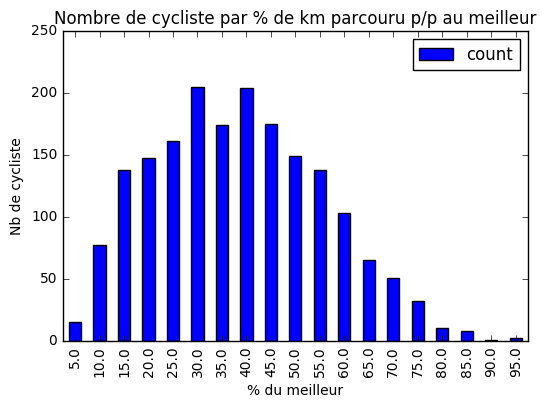

In [74]:
# parametres
title  = u"Nombre de cycliste par % de km parcouru p/p au meilleur"
xlabel = u"% du meilleur"
ylabel = u"Nb de cycliste"
kind   = u"bar"
# algo
ax = pd_df.plot(kind=kind, title = title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# 6) Jointure

# 6.1) construction d'une df à joindre

In [75]:
from pyspark.sql import Row

In [76]:
path_cyclistes = "/logs/cycliste_cyclistes.csv"
target_path    = hdfs_master+path_cyclistes

In [77]:
rdd = sc.textFile(target_path).map(lambda ligne : ligne.split(","))
for i in rdd.take(2):
    print i

[u'cycliste', u'sportif', u'age', u'sexe', u'nb_km', u'vitesse', u'attente']
[u'cycliste_azto8', u'4', u'61', u'homme', u'-2.90410082593', u'13.698933073', u'0.5']


In [78]:
header = rdd.first() #extract header
rdd    = rdd.filter(lambda row : row != header)

In [79]:
rdd    = rdd.map(lambda p: Row( cycliste =       p[0]  , 
                                sportif  = float(p[1])  , 
                                age      = float(p[2]) , 
                                sexe     =       p[3] , 
                                nb_km    = float(p[4]) , 
                                vitesse  = float(p[5]) , 
                                attente  = float(p[6]) ))


In [80]:
champs = OrderedDict([("cycliste"     , StringType() ) ,
                      ("sportif"      , FloatType()  ) ,
                      ("age"          , FloatType()  ) ,
                      ("sexe"         , StringType() ) ,
                      ("nb_km"        , FloatType()  ) ,
                      ("vitesse"      , FloatType()  ) ,
                      ("attente"      , FloatType()  ) ])
fields = [StructField(champ, _type, nullable = True) for champ, _type in champs.iteritems()]
schema = StructType(fields)

In [81]:
cyclistes = spark.createDataFrame(rdd, schema=schema)

In [82]:
cyclistes.show(3)

+--------------+-------+----+-----+---------+---------+-------+
|      cycliste|sportif| age| sexe|    nb_km|  vitesse|attente|
+--------------+-------+----+-----+---------+---------+-------+
|cycliste_azto8|    4.0|61.0|homme|-2.904101|13.698933|    0.5|
|cycliste_azpd5|    2.0|76.0|homme| 9.953279|14.768991|    0.5|
|cycliste_azujk|    4.0|28.0|femme| 16.74885|20.958332|    0.5|
+--------------+-------+----+-----+---------+---------+-------+
only showing top 3 rows



# 6.2) test des valeurs numériques du schéma

In [83]:
colonnes = ["sportif", "age", "nb_km", "vitesse", "attente"]
for col in colonnes : 
    print cyclistes.select(F.sum(col)).collect()

[Row(sum(sportif)=4326.0)]
[Row(sum(age)=87088.0)]
[Row(sum(nb_km)=15487.366467654705)]
[Row(sum(vitesse)=34067.05584406853)]
[Row(sum(attente)=927.5)]


# 6.3) vérification de la logique de jointure

In [84]:
cyclistes.distinct().count()

1855

In [85]:
trajets.select("cycliste").distinct().count()

1855

In [86]:
print trajets.count()

184846


In [87]:
extended_trajets = trajets.join(cyclistes, on="cycliste")

In [88]:
print extended_trajets.count()

184846


# 6.4) Chargeons 700 M de data

In [89]:
path_cyclistes   = "/logs/trajets.csv"
target_path      = hdfs_master+path_cyclistes

## 6.4.1) le csv contient une ligne de header, qu'on enlève à travers une rdd avant de la convertir en dataframe.

In [90]:
rdd    = sc.textFile(target_path).map(lambda ligne : ligne.split(","))
header = rdd.first() 
rdd    = rdd.filter(lambda row : row != header)
rdd    = rdd.map(lambda p: Row( station_depart  = p[0], 
                                cycliste        = p[1], 
                                velo            = p[2], 
                                heure_de_depart = float(p[3]), 
                                heure_de_fin    = float(p[4]), 
                                duree           = float(p[5]), 
                                distance        = float(p[6]), 
                                station_arrivee = p[7]))


## 6.4.2 ) conversion en dataframe

In [91]:
champs = OrderedDict([("station_depart"     , StringType() ) ,
                      ("cycliste"           , StringType() ) ,
                      ("velo"               , StringType() ) ,
                      ("heure_de_depart"    , FloatType()  ) ,
                      ("heure_de_fin"       , FloatType()  ) ,
                      ("duree"              , FloatType()  ) ,
                      ("distance"           , FloatType()  ) ,
                      ("station_arrivee"    , StringType() ) ])

fields = [StructField(champ, _type, nullable = True) for champ, _type in champs.iteritems()]
schema = StructType(fields)

trajets_700_Mo = spark.createDataFrame(rdd, schema)

In [92]:
trajets_700_Mo.show()

+--------------+--------------+--------------------+---------------+------------+---------+---------+---------------+
|station_depart|      cycliste|                velo|heure_de_depart|heure_de_fin|    duree| distance|station_arrivee|
+--------------+--------------+--------------------+---------------+------------+---------+---------+---------------+
|         azd40|cycliste_azto8|velo_aruo1_148925...|   1.48925658E9|1.48925658E9| 4.325838| 7.071068|          aecb4|
|         azew2|cycliste_azpd5|velo_aeiq9_148925...|   1.48925658E9|1.48925658E9| 4.317812|7.2111025|          azqn6|
|         aejw4|cycliste_azujk|velo_azes8_148925...|   1.48925658E9|1.48925658E9|  4.31454| 9.219544|          azim1|
|         aetl1|cycliste_azu15|velo_arudb_148925...|   1.48925658E9|1.48925658E9| 4.310658|1.4142135|          azrtp|
|         aetdw|cycliste_azi24|velo_ars18_148925...|   1.48925658E9|1.48925658E9| 4.308077|3.6055512|          azew2|
|         arygc|cycliste_aztpk|velo_aziqj_148925...|   1

In [ ]:
trajets_700_Mo.count()

In [93]:
extended_trajets_700_Mo = trajets_700_Mo.join(cyclistes, on="cycliste")

In [ ]:
extended_trajets_700_Mo.distinct().count()

In [ ]:
extended_trajets_700_Mo.show()

# 7) faire du sql

## 7.1) on enregistre la dataframe en tant que table sql

In [94]:
extended_trajets_700_Mo.createOrReplaceTempView("trajets")

## 7.2) on utilise la spark session pour faire du SQL dessus

In [95]:
requete ="""
    select *
    from   trajets
    limit  1
"""
spark.sql(requete).collect()

[Row(cycliste=u'cycliste_azem5', station_depart=u'azfk9', velo=u'velo_azeq6_1489256536.82', heure_de_depart=1489256576.0, heure_de_fin=1489256576.0, duree=0.00446319580078125, distance=0.0, station_arrivee=u'azfk9', sportif=4.0, age=75.0, sexe=u'homme', nb_km=10.611597061157227, vitesse=20.202173233032227, attente=0.5)]

In [96]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [97]:
extended_trajets_700_Mo.show(3)

+--------------+--------------+--------------------+---------------+------------+---------+---------+---------------+-------+----+-----+---------+---------+-------+
|      cycliste|station_depart|                velo|heure_de_depart|heure_de_fin|    duree| distance|station_arrivee|sportif| age| sexe|    nb_km|  vitesse|attente|
+--------------+--------------+--------------------+---------------+------------+---------+---------+---------------+-------+----+-----+---------+---------+-------+
|cycliste_azem5|         aefhv|velo_aryo8_148925...|   1.48925658E9|1.48925658E9| 1.397341|5.8309517|          aey79|    4.0|75.0|homme|10.611597|20.202173|    0.5|
|cycliste_azem5|         aze46|velo_aerwc_148925...|   1.48925658E9|1.48925658E9|1.3242779|6.4031243|          arygc|    4.0|75.0|homme|10.611597|20.202173|    0.5|
|cycliste_azem5|         ae134|velo_aze60_148925...|   1.48925658E9|1.48925658E9| 1.334538|5.8309517|          aecb4|    4.0|75.0|homme|10.611597|20.202173|    0.5|
+---------

# 8) Machine Learning : Prédiction de la sportivité (modalité [-0.5, 0, 2, 4, 6 ])

## 8.1) préparation de la dataFrame

Les RF ne fonctionnent qu'avec des nombres, on va donc commencer par se limiter aux colonnes qui sont des nombres

In [151]:
type_voulu         = "float"
colonnes_acceptees = [(colonne, type_) for colonne, type_ in extended_trajets_700_Mo.dtypes if type_ == type_voulu]

In [152]:
colonne_a_predire = "sportif"
colonne_d_entree  = [ colonne for colonne, type_ in colonnes_acceptees if colonne !=colonne_a_predire]

on doit créer colonne, avec toutes les données "features" utiles dedans : un vecteur

In [153]:
from pyspark.ml.feature import VectorAssembler

In [154]:
assembler                             = VectorAssembler(inputCols = colonne_d_entree,
                                                        outputCol = "features")
trajets_avec_colonne_feature          = assembler.transform(extended_trajets_700_Mo)

par défaut les algorithmes attendent une colonne "features" (qui est un vecteur) et une colonne "label" à prédire
=> on renomme donc la colonne a prédire en "label"

In [155]:
trajets_avec_colonne_feature_et_label = trajets_avec_colonne_feature.withColumnRenamed(colonne_a_predire, "label")

In [156]:
trajets_avec_colonne_feature_et_label.cache()

DataFrame[cycliste: string, station_depart: string, velo: string, heure_de_depart: float, heure_de_fin: float, duree: float, distance: float, station_arrivee: string, label: float, age: float, sexe: string, nb_km: float, vitesse: float, attente: float, features: vector]

In [203]:
trajets_avec_colonne_feature_et_label.show(2)

+--------------+--------------+--------------------+---------------+------------+---------+---------+---------------+-----+----+-----+---------+---------+-------+--------------------+
|      cycliste|station_depart|                velo|heure_de_depart|heure_de_fin|    duree| distance|station_arrivee|label| age| sexe|    nb_km|  vitesse|attente|            features|
+--------------+--------------+--------------------+---------------+------------+---------+---------+---------------+-----+----+-----+---------+---------+-------+--------------------+
|cycliste_azem5|         aetlb|velo_aefw3_148925...|    1.4892567E9| 1.4892567E9|1.3405218|5.3851647|          arygc|  4.0|75.0|homme|10.611597|20.202173|    0.5|[1.489256704E9,1....|
|cycliste_azem5|         arygc|velo_arfv8_148925...|    1.4892567E9| 1.4892567E9| 1.471297| 4.472136|          azyn7|  4.0|75.0|homme|10.611597|20.202173|    0.5|[1.489256704E9,1....|
+--------------+--------------+--------------------+---------------+------------

# 8.2) création d'un jeu de test et d'apprentissage

In [158]:
pourcentage_train = 80/float(100)
pourcentage_test  = 1 - pourcentage_train
splits            = trajets_avec_colonne_feature_et_label.randomSplit((pourcentage_train,pourcentage_test))

In [159]:
train = splits[0]
test  = splits[1]

# 8.3) modélisation avec un arbre de décision (en mode régression)

In [137]:
from pyspark.ml.regression import DecisionTreeRegressor 

In [171]:
dt           = DecisionTreeRegressor()

In [172]:
model        = dt.fit(train)

In [173]:
predictions  = model.transform(test).cache()

In [176]:
modelisation = predictions.select(["features", "label", "prediction"]).cache()

In [177]:
modelisation.sample(False, 30/float(a.count())).show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[1.489277696E9,1....|  0.0|1.3879689390152914|
|[1.489262336E9,1....|  4.0|3.1150283411302233|
|[1.489266304E9,1....|  0.0|2.9742257043630804|
|[1.489264128E9,1....|  6.0|2.8386627948356606|
|[1.489274496E9,1....|  6.0| 3.728965173582012|
|[1.489266048E9,1....|  2.0|3.6467812584399417|
|[1.489264128E9,1....|  6.0|3.6467812584399417|
|[1.489271552E9,1....| -0.5|0.5489781950068948|
|[1.489278464E9,1....|  0.0|1.4260374826644027|
|[1.489257344E9,1....| -0.5|-0.415278853601859|
|[1.489275392E9,1....|  6.0|3.6467812584399417|
|[1.489259776E9,1....|  6.0|3.6467812584399417|
|[1.489261952E9,1....|  6.0|3.1150283411302233|
|[1.48925952E9,1.4...|  4.0|3.6467812584399417|
|[1.489258752E9,1....|  2.0|0.3723498679849447|
|[1.489259648E9,1....|  4.0|3.6467812584399417|
|[1.489270016E9,1....| -0.5|-0.415278853601859|
|[1.489273984E9,1....|  2.0|2.8386627948

## 8.3.1) evaluation du modèle

In [178]:
from pyspark.ml.evaluation import RegressionEvaluator

In [182]:
regression_evaluator = RegressionEvaluator()

In [183]:
regression_evaluator.getMetricName()

'rmse'

In [185]:
regression_evaluator.evaluate(predictions)

2.069576015260251

# 8.4) modélisation avec un random Forest

In [186]:
from pyspark.ml.regression import RandomForestRegressor 

In [187]:
algorithme = RandomForestRegressor()

In [189]:
model = algorithme.fit(train)

In [190]:
predictions  = model.transform(test).cache()

In [191]:
modelisation = predictions.select(["features", "label", "prediction"]).cache()

In [192]:
modelisation.sample(False, 30/float(a.count())).show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[1.489273344E9,1....|  0.0|0.7460189791495305|
|[1.489276416E9,1....|  4.0|2.9568864882885504|
|[1.48927552E9,1.4...|  2.0| 2.368687203926452|
|[1.4892736E9,1.48...|  0.0|3.0014838048030237|
|[1.489275904E9,1....|  6.0|2.6695609346747533|
|[1.489262976E9,1....|  6.0| 2.509243852912974|
|[1.48925824E9,1.4...|  4.0|2.5125284377385175|
|[1.489271424E9,1....|  4.0| 3.557415920029708|
|[1.489260288E9,1....|  2.0|  1.52001138987381|
|[1.489273856E9,1....| -0.5|3.0624199999250776|
|[1.489275264E9,1....| -0.5|0.2407045357402715|
|[1.489273088E9,1....|  4.0|3.4997121376496154|
|[1.48927744E9,1.4...|  0.0| 2.352330841355886|
|[1.489269504E9,1....|  6.0| 3.261649342770194|
|[1.489259008E9,1....|  6.0| 3.056154751226397|
|[1.489264384E9,1....|  0.0| 1.419365171386762|
|[1.489278848E9,1....|  4.0|3.6469466879966794|
|[1.489266048E9,1....|  4.0|3.1046341198

## 8.4.1) evaluation du RF

In [193]:
regression_evaluator.evaluate(predictions)

2.094451030162627

# 8.5) changeons le type de question : régression -> classification

### 8.5.1) transformer les float en string (cast)

In [236]:
col_float  = "label"

In [237]:
trajets_avec_colonne_feature_et_label = trajets_avec_colonne_feature_et_label.withColumn(col_float, 
                                                                                         trajets_avec_colonne_feature_et_label[col_float].cast(StringType()))

### 8.5.2) transformer les string en catégories / indexes (stringIndexer) 

In [238]:
from pyspark.ml.feature import StringIndexer

In [239]:
col_string = col_float
new_col    = "indexed"
indexer    = StringIndexer(inputCol  = col_string   , 
                           outputCol = new_col )

In [241]:
model                  = indexer.fit(trajets_avec_colonne_feature_et_label)
trajets_sportif_indexe = model.transform(trajets_avec_colonne_feature_et_label)

### regardons le résultat à cette étape

In [253]:
nb_row_to_print    = 20
sample_pourcentage = float(nb_row_to_print)/trajets_sportif_indexe.count()
trajets_sportif_indexe.sample(False, sample_pourcentage).select([col_string, new_col]).sort(new_col).show()

+-----+-------+
|label|indexed|
+-----+-------+
|  4.0|    0.0|
|  4.0|    0.0|
|  4.0|    0.0|
|  2.0|    1.0|
|  2.0|    1.0|
|  2.0|    1.0|
|  6.0|    2.0|
|  6.0|    2.0|
|  6.0|    2.0|
|  6.0|    2.0|
|  6.0|    2.0|
|  6.0|    2.0|
| -0.5|    3.0|
| -0.5|    3.0|
| -0.5|    3.0|
|  0.0|    4.0|
|  0.0|    4.0|
+-----+-------+



### 8.5.3) Transformons les indexes en colonnes (one-hot-encoding)

In [246]:
from pyspark.ml.feature import OneHotEncoder

In [270]:
name_encoded_col = "label2"
encoder = OneHotEncoder(inputCol=new_col, outputCol=name_encoded_col)

In [271]:
a = encoder.transform(trajets_sportif_indexe)

In [272]:
a.select([name_encoded_col, new_col]).sample(False, sample_pourcentage).sort(name_encoded_col).show()

+-------------+-------+
|       label2|indexed|
+-------------+-------+
|    (4,[],[])|    4.0|
|    (4,[],[])|    4.0|
|    (4,[],[])|    4.0|
|    (4,[],[])|    4.0|
|(4,[0],[1.0])|    0.0|
|(4,[0],[1.0])|    0.0|
|(4,[0],[1.0])|    0.0|
|(4,[1],[1.0])|    1.0|
|(4,[1],[1.0])|    1.0|
|(4,[1],[1.0])|    1.0|
|(4,[1],[1.0])|    1.0|
|(4,[1],[1.0])|    1.0|
|(4,[1],[1.0])|    1.0|
|(4,[2],[1.0])|    2.0|
|(4,[2],[1.0])|    2.0|
|(4,[2],[1.0])|    2.0|
|(4,[2],[1.0])|    2.0|
|(4,[2],[1.0])|    2.0|
|(4,[2],[1.0])|    2.0|
|(4,[3],[1.0])|    3.0|
+-------------+-------+
only showing top 20 rows



### 8.5.4) créons les jeux de train et test (split)

In [258]:
pourcentage_train = 80/float(100)
pourcentage_test  = 1 - pourcentage_train
splits            = a.randomSplit((pourcentage_train,pourcentage_test))
train = splits[0].cache()
test  = splits[1].cache()

In [259]:
train.count()

6215238

In [263]:
a.show(2)

+--------------+--------------+--------------------+---------------+------------+---------+---------+---------------+-----+----+-----+---------+---------+-------+--------------------+-------+-------------+
|      cycliste|station_depart|                velo|heure_de_depart|heure_de_fin|    duree| distance|station_arrivee|label| age| sexe|    nb_km|  vitesse|attente|            features|indexed|       label2|
+--------------+--------------+--------------------+---------------+------------+---------+---------+---------------+-----+----+-----+---------+---------+-------+--------------------+-------+-------------+
|cycliste_azem5|         aetlb|velo_aefw3_148925...|    1.4892567E9| 1.4892567E9|1.3405218|5.3851647|          arygc|  4.0|75.0|homme|10.611597|20.202173|    0.5|[1.489256704E9,1....|    0.0|(4,[0],[1.0])|
|cycliste_azem5|         arygc|velo_arfv8_148925...|    1.4892567E9| 1.4892567E9| 1.471297| 4.472136|          azyn7|  4.0|75.0|homme|10.611597|20.202173|    0.5|[1.489256704E9

## 8.8.5) RandomForest Classifier

In [260]:
from pyspark.ml.classification import RandomForestClassifier

In [277]:
classifier = RandomForestClassifier(labelCol="indexed")

In [278]:
model = classifier.fit(train)

In [279]:
predictions = model.transform(test)

In [281]:
predictions.columns

['cycliste',
 'station_depart',
 'velo',
 'heure_de_depart',
 'heure_de_fin',
 'duree',
 'distance',
 'station_arrivee',
 'label',
 'age',
 'sexe',
 'nb_km',
 'vitesse',
 'attente',
 'features',
 'indexed',
 'label2',
 'rawPrediction',
 'probability',
 'prediction']

## 8.5.6) Evaluation de la classification

In [280]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [282]:
evaluator = MulticlassClassificationEvaluator(labelCol="indexed")

In [285]:
evaluator.getMetricName()

'f1'

In [283]:
evaluator.evaluate(predictions)

0.39510258384942704

# taux de bonne prediction

In [303]:
bonnes_predictions    = predictions.filter("indexed == prediction").count()
nb_de_lignes          = predictions.count()
tx_bonnes_predictions = bonnes_predictions / float(nb_de_lignes)
tx_bonnes_predictions

0.40922876071129916

## 8.5.7) Essayer plusieurs profondeurs d'arbre 

In [296]:
from time import time

In [299]:
perf = {}
numTrees = [50, 100, 200]
for localNumTree in numTrees:
    debut       = time()
    classifier  = RandomForestClassifier(labelCol="indexed", numTrees=localNumTree)
    model       = classifier.fit(train)
    predictions = model.transform(test)
    performance = evaluator.evaluate(predictions)
    duree       = time() - debut
    print localNumTree, performance, duree
    perf[localNumTree] = {"perf" : performance, "duree" : duree}

50 0.395710559071 341.233059168
100 0.395292881373 722.701714993
200 0.395605594242 1433.24287605


### Graphique de performance

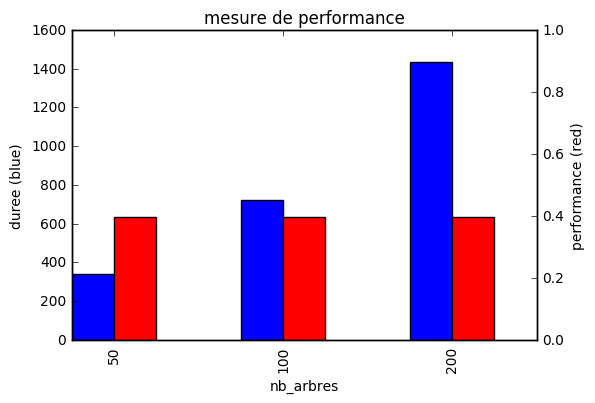

In [411]:
from matplotlib import pyplot as plt

# Pandas dataFrame
pd_df            = pd.DataFrame(perf).T
pd_df.index.name = "nb_arbres"

# Matplotlib figure
fig = plt.figure()

#Axe pour la première serie
ax  = fig.add_subplot(111)
ax.set_ylabel("duree (blue)")
pd_df["duree"].plot(kind="bar", ax = ax, position=1, width=0.25)

#Axe pour seconde  serie
ax2 = ax.twinx()
ax2.set_ylabel ("performance (red)")
ax2.set_ylim(0, 1)
pd_df["perf"].plot(kind="bar", color='red',  ax=ax2, position=0, width=0.25)

# Titre et affichage du graphique
plt.title("mesure de performance")
plt.show()

## extraction des importances de features : 

In [311]:
model.featureImportances

SparseVector(8, {0: 0.0, 1: 0.0, 2: 0.0231, 3: 0.0086, 4: 0.2181, 5: 0.0903, 6: 0.6598})

In [318]:
train.select("features").take(2)

[Row(features=DenseVector([1489263872.0, 1489263872.0, 1.2954, 5.6569, 75.0, 10.6116, 20.2022, 0.5])),
 Row(features=DenseVector([1489277312.0, 1489277312.0, 1.2956, 5.831, 75.0, 10.6116, 20.2022, 0.5]))]